In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
df = pd.read_csv('..\\data\\csv\\FY_2022-2025.csv')
df.shape

(9063, 37)

In [2]:
df.info()
missing = df.filter(like='ERR').isna().sum().sort_values(ascending=False)
missing.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9063 entries, 0 to 9062
Data columns (total 37 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Hospital CCN                                 9063 non-null   object 
 1     Payment adjustment factor                  9061 non-null   float64
 2   Payment reduction percentage                 9061 non-null   float64
 3   Dual proportion                              9061 non-null   float64
 4   Peer group assignment                        9061 non-null   float64
 5   Neutrality modifier                          9061 non-null   float64
 6   Number of eligible discharges for AMI        8752 non-null   object 
 7   ERR for AMI                                  8752 non-null   object 
 8   Peer group median ERR for AMI                9061 non-null   float64
 9   Penalty indicator for AMI                    9061 non-null   object 
 10  

ERR for pneumonia                      3153
Peer group median ERR for pneumonia    3046
ERR for CABG                           1935
ERR for THA/TKA                         421
ERR for AMI                             311
dtype: int64

**Which hospitals are penalized most often, and what drives those penalties?**

- This cell identifies hospitals penalized under Medicare's payment reduction program using the `Any_Penalty` indicator.
- Penalties are tracked for six conditions: AMI, COPD, HF, pneumonia, CABG, and THA/TKA.
- The summary table shows which conditions result in the most penalties, helping target improvement efforts.
- The penalty summary focuses on high-impact conditions and hospitals with frequent penalties.

In [3]:
penalty_cols = [c for c in df.columns if 'Penalty indicator' in c]
df['Any_Penalty'] = df[penalty_cols].eq('Y').any(axis=1)

penalty_summary = (
    df[penalty_cols + ['Any_Penalty']]
    .melt(var_name='Condition', value_name='Penalty')
    .assign(Condition=lambda x: x['Condition'].str.extract(r'for (.+?)\s*$')[0])
    .query("Penalty == 'Y'")
    .groupby('Condition').size()
    .rename('Hospitals_Penalized')
    .sort_values(ascending=False)
)
penalty_summary

Condition
HF           3956
COPD         3554
THA/TKA      2763
pneumonia    2680
AMI          2669
CABG         1292
Name: Hospitals_Penalized, dtype: int64

**Distribution and Top Hospitals by Medicare Payment Reduction**

- The histogram visualizes the distribution of payment reduction percentages across all hospitals, highlighting the prevalence and severity of Medicare penalties.
- The table below lists the 10 hospitals with the highest payment reduction percentages, including their CCN and peer group assignment.
- This is to identify outliers and target high-impact hospitals for intervention.

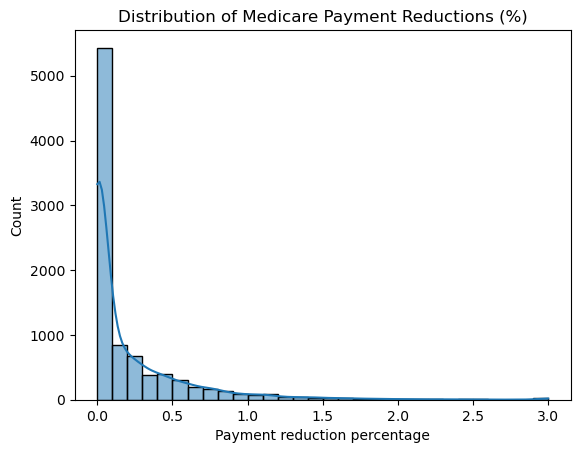

,Hospital CCN,Payment reduction percentage,Peer group assignment
130,30112,3.0,1.0
206,50030,3.0,5.0
452,50766,3.0,3.0
683,100260,3.0,1.0
1243,190298,3.0,1.0
1271,220008,3.0,4.0
1281,220029,3.0,2.0
2057,360361,3.0,4.0
2619,450774,3.0,1.0
2917,670005,3.0,1.0


In [4]:
sns.histplot(df['Payment reduction percentage'], bins=30, kde=True)
plt.title('Distribution of Medicare Payment Reductions (%)')
plt.show()

top_10_penalized = (
    df.nlargest(10, 'Payment reduction percentage')
    [['Hospital CCN', 'Payment reduction percentage', 'Peer group assignment']]
)
top_10_penalized

**Peer Group Performance Summary**

- This table aggregates hospital performance by peer group assignment.
- Key metrics include:
    - **Hospitals**: Number of hospitals in each peer group.
    - **Avg_Payment_Reduction**: Mean Medicare payment reduction percentage.
    - **Any_Penalty_Rate**: Proportion of hospitals penalized in each group.
    - **Mean_DUAL**: Average dual-eligible patient share.
- This summary compares peer groups, identifying underperforming segments, and target improvement strategies.

In [5]:
peer_stats = (
    df.groupby('Peer group assignment')
      .agg(
          Hospitals=('Hospital CCN', 'count'),
          Avg_Payment_Reduction=('Payment reduction percentage', 'mean'),
          Any_Penalty_Rate=('Any_Penalty', 'mean'),
          Mean_DUAL=('Dual proportion', 'mean')
      )
      .round(3)
)
peer_stats

,Hospitals,Avg_Payment_Reduction,Any_Penalty_Rate,Mean_DUAL
Peer group assignment,,,,
1.0,1813,0.231,0.673,0.097
2.0,1812,0.241,0.839,0.167
3.0,1813,0.213,0.823,0.213
4.0,1812,0.208,0.825,0.271
5.0,1811,0.180,0.750,0.465


**Top 10 Hospitals with Highest ERRs and Penalties**

- This analysis identifies the hospitals with the worst Excess Readmission Ratios (ERR) among those penalized for each condition.
- The table lists the 10 highest ERRs, showing hospital CCN, condition, ERR value, and peer group assignment.
- This pinpoints outlier hospitals and conditions where penalties coincide with extreme performance issues.
- Target these hospitals for focused intervention and improvement efforts.

In [6]:
# Build tidy long table of ERR & Penalty
long = []
for cond in ['AMI', 'COPD', 'HF', 'pneumonia', 'CABG', 'THA/TKA']:
    long.append(
        df[['Hospital CCN', 'Peer group assignment', f'ERR for {cond}', f'Penalty indicator for {cond}']]
        .rename(columns={
            f'ERR for {cond}': 'ERR',
            f'Penalty indicator for {cond}': 'Penalty'
        })
        .assign(Condition=cond)
    )
long = pd.concat(long)

# Ensure ERR is numeric and drop NaNs
long['ERR'] = pd.to_numeric(long['ERR'], errors='coerce')
long = long.dropna(subset=['ERR'])

# Top 10 worst ERRs with penalties
worst = (
    long.query("Penalty == 'Y'")
        .nlargest(10, 'ERR')
        .reset_index(drop=True)
)
worst[['Hospital CCN', 'Condition', 'ERR', 'Peer group assignment']]

,Hospital CCN,Condition,ERR,Peer group assignment
0,30112,THA/TKA,1.643046,1.0
1,340028,THA/TKA,1.619934,4.0
2,140082,THA/TKA,1.562931,5.0
3,040078,THA/TKA,1.561142,3.0
4,100264,THA/TKA,1.557250,1.0
5,030112,THA/TKA,1.516154,1.0
6,140082,THA/TKA,1.507559,5.0
7,450104,THA/TKA,1.492275,2.0
8,50030,pneumonia,1.491888,5.0
9,220073,THA/TKA,1.484415,5.0


**Correlation Matrix of Numeric Features**

- This heatmap visualizes the pairwise correlations among all numeric variables in the dataset (excluding the constant 'Year').
- Strong positive or negative correlations highlight relationships between hospital metrics, such as payment reductions, dual-eligible share, and ERRs.
- This matrix to identifies potential confounders, redundant features, or candidates for further analysis and modeling.

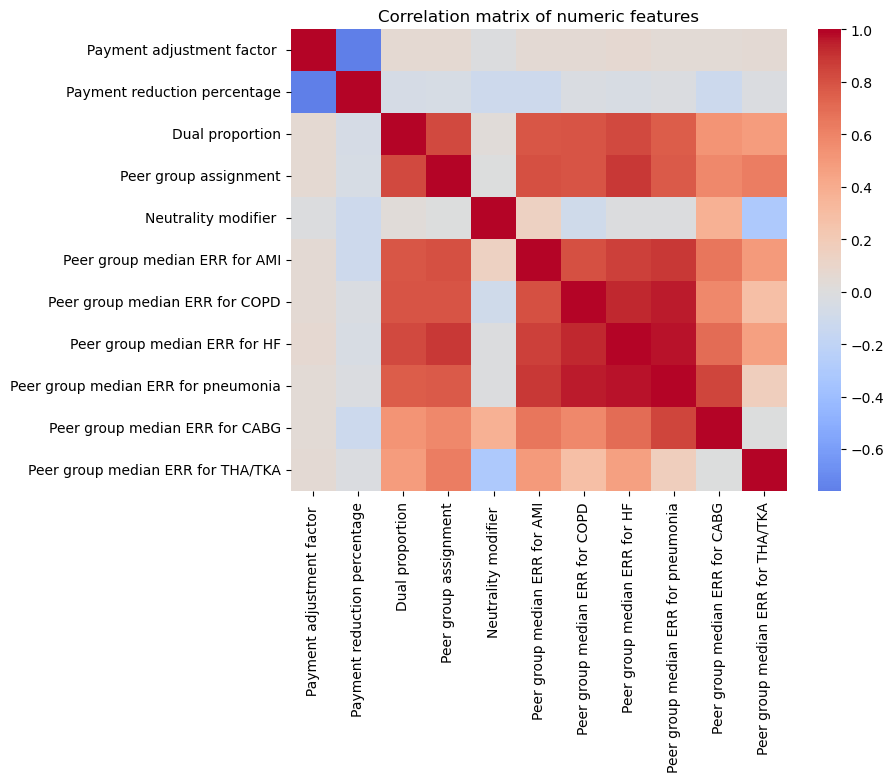

In [7]:
numeric = df.select_dtypes(include='number').drop(columns=['Year'])  # constant
corr = numeric.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation matrix of numeric features')
plt.show()

**Actionable Insights: Targeting High-Priority Hospitals and Conditions**

- **High-priority hospitals:** `{len(priority)}` hospitals face payment reductions of 1% or more, indicating significant financial impact and need for intervention.
- **Underperforming peer groups:** Peer groups with penalty rates above 50% are `{underperforming_peers.index.tolist()}`. These segments should be prioritized for performance improvement strategies.
- **Top penalty-driving conditions:** The three conditions most frequently resulting in penalties are `{conditions_to_watch}`. Focusing on these areas can yield the greatest improvement in hospital performance and Medicare compliance.

These insights are to guide resource allocation efforts, quality improvement initiatives, and targeted support for hospitals and peer groups most at risk.

In [8]:

priority = df[df['Payment reduction percentage'] >= 1.0]
underperforming_peers = peer_stats[peer_stats['Any_Penalty_Rate'] > 0.5]
conditions_to_watch = penalty_summary.head(3).index.tolist()

print("ACTIONABLE INSIGHTS")
print("-" * 40)
print(f"• {len(priority)} hospitals face ≥1% payment reduction.")
print(f"• Peer groups with >50% penalty rate: {underperforming_peers.index.tolist()}")
print(f"• Top 3 conditions to target for improvement: {conditions_to_watch}")

ACTIONABLE INSIGHTS
----------------------------------------
• 439 hospitals face ≥1% payment reduction.
• Peer groups with >50% penalty rate: [1.0, 2.0, 3.0, 4.0, 5.0]
• Top 3 conditions to target for improvement: ['HF', 'COPD', 'THA/TKA']


**Top 10 Hospitals by Estimated AMI Dollar Loss**

- This analysis estimates the financial impact of AMI-related payment reductions for each hospital.
- The `AMI_DollarLoss` metric is calculated as the product of eligible AMI discharges and the reduction in DRG payment ratio.
- The table below lists the 10 hospitals with the highest estimated dollar losses, highlighting priority targets for financial intervention and improvement.

In [9]:
# AMI-specific columns
drg_col = 'DRG payment ratio for AMI'
vol_col = 'Number of eligible discharges for AMI'

# Ensure both are numeric
df[drg_col] = pd.to_numeric(df[drg_col], errors='coerce')
df[vol_col] = pd.to_numeric(df[vol_col], errors='coerce')

# Dollar loss estimate
df['AMI_DollarLoss'] = (1 - df[drg_col]).fillna(0) * df[vol_col].fillna(0)

# Top 10 hospitals by estimated loss
top_dollar_loss = (
    df[['Hospital CCN', 'AMI_DollarLoss']]
    .query("AMI_DollarLoss > 0")
    .sort_values('AMI_DollarLoss', ascending=False)
    .head(10)
)
top_dollar_loss

,Hospital CCN,AMI_DollarLoss
1299,220077,1085.773598
7920,340002,942.809951
1879,340040,905.652851
2414,440082,895.398923
7342,220077,887.608722
1860,340002,868.675100
4301,220077,867.897690
8449,440002,866.559887
7939,340040,859.318005
2120,370215,848.747483


**Benchmarking AMI ERRs Against Peer Group Medians**

- This function compares each hospital’s Excess Readmission Ratio (ERR) for AMI to the median ERR of its peer group.
- The output table includes:
    - **Hospital CCN**
    - **ERR for AMI**
    - **Median_ERR_AMI** (peer group median)
    - **Above_Peer_Median** (True if hospital’s ERR exceeds peer group median)
- This benchmark to identifies hospitals with above-average readmission rates within their peer group, highlighting candidates for targeted improvement.

In [10]:
def benchmark_condition(condition='AMI'):
    base = df[['Hospital CCN', 'Peer group assignment', f'ERR for {condition}']].dropna()

    base[f'ERR for {condition}'] = pd.to_numeric(base[f'ERR for {condition}'], errors='coerce')

    medians = base.groupby('Peer group assignment')[f'ERR for {condition}'].median()

    base = base.merge(medians.rename(f'Median_ERR_{condition}'), on='Peer group assignment')

    base['Above_Peer_Median'] = base[f'ERR for {condition}'] > base[f'Median_ERR_{condition}']
    
    return base[['Hospital CCN', f'ERR for {condition}', f'Median_ERR_{condition}', 'Above_Peer_Median']]

benchmark_condition('AMI').head()

,Hospital CCN,ERR for AMI,Median_ERR_AMI,Above_Peer_Median
0,10001,0.948341,0.995543,False
1,10005,0.997197,0.995214,True
2,10006,0.970391,0.995214,False
3,10007,1.013923,0.996324,True
4,10008,1.022645,0.996947,True


**Dual-Eligible Share by Penalty Status**

- This boxplot compares the distribution of dual-eligible patient proportions between hospitals penalized and not penalized under Medicare's payment reduction program.
- Higher dual-eligible shares may indicate greater socioeconomic risk among patient populations.
- The visualization helps assess whether hospitals serving more dual-eligible patients are more likely to receive penalties.

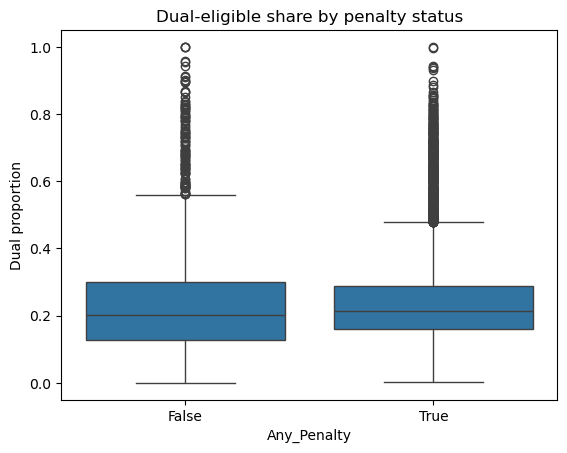

In [11]:
sns.boxplot(x='Any_Penalty', y='Dual proportion', data=df)
plt.title('Dual-eligible share by penalty status')
plt.show()

**Top 10 Small Peer Group Hospitals with Lowest Dual-Eligible Share (No Penalty)**

- This table lists the 10 hospitals in peer group 1 that were not penalized and have the lowest proportion of dual-eligible patients.
- These hospitals may serve as benchmarks for performance and patient mix in small peer groups.
- This comparison identifies characteristics associated with lower penalty risk and dual-eligible share; smaller hospitals with no penalties

In [12]:
mask = (df['Peer group assignment'] == 1) & (~df['Any_Penalty'])
good_small = (
    df.loc[mask, ['Hospital CCN', 'Dual proportion']]
      .nsmallest(10, 'Dual proportion')
)
good_small

,Hospital CCN,Dual proportion
704,100298,0.0
1244,190302,0.0
2970,670259,0.0
2979,670314,0.0
4244,190302,0.0
6008,670259,0.0
6013,670285,0.0
6571,070040,0.0
7071,150191,0.0
7286,190302,0.0


**Relationship Between AMI Volume and Excess Readmission Ratio (ERR)**

- This scatterplot with regression line explores the association between the number of eligible AMI discharges and the hospital's Excess Readmission Ratio (ERR).
- Each point represents a hospital; the x-axis is AMI discharge volume, and the y-axis is ERR for AMI.
- The visualization aims to assess whether higher patient volumes are linked to better or worse readmission performance, potentially informing resource allocation and quality improvement strategies.

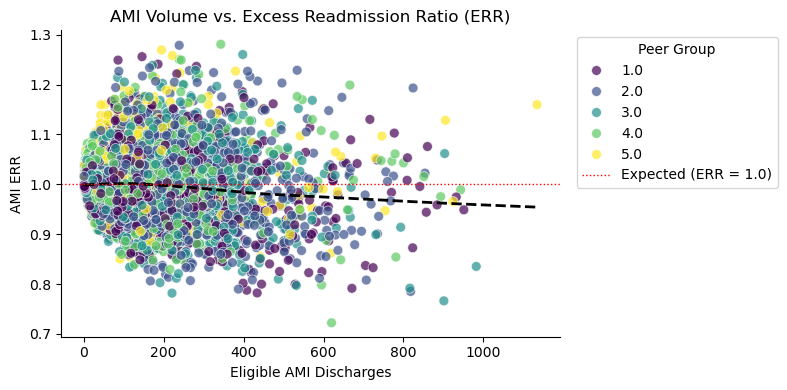

In [18]:
ami = (df[['Hospital CCN', 'Peer group assignment',
           'Number of eligible discharges for AMI',
           'ERR for AMI']]
       .dropna()
       .rename(columns={'Number of eligible discharges for AMI': 'AMI_Volume',
                        'ERR for AMI': 'AMI_ERR'}))
ami['AMI_ERR'] = pd.to_numeric(ami['AMI_ERR'], errors='coerce')
ami = ami.dropna()

plt.figure(figsize=(8, 4))
sns.scatterplot(
    data=ami,
    x='AMI_Volume',
    y='AMI_ERR',
    hue='Peer group assignment',
    palette='viridis',
    alpha=0.7,
    s=50
)

sns.regplot(
    data=ami,
    x='AMI_Volume',
    y='AMI_ERR',
    scatter=False,
    color='black',
    lowess=True,
    line_kws={'lw': 2, 'ls': '--'}
)

plt.axhline(1.0, color='red', ls=':', lw=1, label='Expected (ERR = 1.0)')
plt.title('AMI Volume vs. Excess Readmission Ratio (ERR)')
plt.xlabel('Eligible AMI Discharges')
plt.ylabel('AMI ERR')
plt.legend(title='Peer Group', bbox_to_anchor=(1.02, 1), loc='upper left')
sns.despine()
plt.tight_layout()
plt.show()

**Top 15 Hospitals by Highest Excess Readmission Ratio (ERR) Across All Conditions**

- This analysis identifies the hospital with the single worst ERR for any condition, per hospital.
- The function scans all ERR metrics (AMI, COPD, HF, pneumonia, CABG, THA/TKA) and selects the highest value for each hospital.
- The table lists the 15 hospitals with the most extreme ERRs, highlighting outliers for targeted review and intervention.
- This summary aims to prioritize hospitals with the greatest opportunity for improvement in readmission performance.

In [14]:
def worst_metric_per_hospital():
    cols = [c for c in df.columns if 'ERR' in c and 'Penalty' not in c]
    tidy = (df[['Hospital CCN'] + cols]
            .melt(id_vars='Hospital CCN', var_name='Metric', value_name='ERR')
            .dropna())
    tidy['ERR'] = pd.to_numeric(tidy['ERR'], errors='coerce')
    # Highest ERR per hospital
    return (tidy.sort_values('ERR', ascending=False)
                .drop_duplicates('Hospital CCN')
                .head(15))
worst_metric_per_hospital()

,Hospital CCN,Metric,ERR
90760,30112,ERR for THA/TKA,1.643046
98565,340028,ERR for THA/TKA,1.619934
91503,140082,ERR for THA/TKA,1.562931
96829,040078,ERR for THA/TKA,1.561142
91314,100264,ERR for THA/TKA,1.557250
92149,260027,ERR for THA/TKA,1.531727
93740,030112,ERR for THA/TKA,1.516154
93119,450104,ERR for THA/TKA,1.492275
54584,50030,ERR for pneumonia,1.491888
91926,220073,ERR for THA/TKA,1.484415


**Penalty Rate Heatmap by Condition and Peer Group**

- This heatmap visualizes the proportion of hospitals penalized for each condition across peer groups.
- Each cell shows the penalty rate (percentage of hospitals penalized) for a given condition and peer group.
- Darker shades indicate higher penalty rates, highlighting which peer groups and conditions are most affected.
- This visualization identifies high-risk segments to target improvement efforts where penalties are most prevalent.

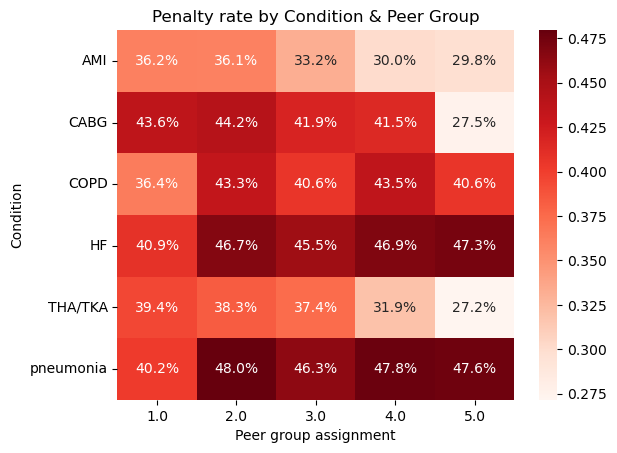

In [15]:
penalty_heatmap = (
    long.assign(Penalty=lambda x: x['Penalty'] == 'Y')
        .groupby(['Condition', 'Peer group assignment'])['Penalty']
        .mean()
        .unstack(fill_value=0)
)
sns.heatmap(penalty_heatmap, annot=True, fmt='.1%', cmap='Reds')
plt.title('Penalty rate by Condition & Peer Group')
plt.show()

**Top 10 Hospitals with Highest Peer-Normalized ERR for Heart Failure (HF)**

- This analysis ranks hospitals by their z-score for Excess Readmission Ratio (ERR) in Heart Failure (HF), normalized within each peer group.
- The z-score measures how far a hospital's ERR deviates from its peer group mean, highlighting outliers with unusually high readmission rates.
- The table lists the 10 hospitals with the highest peer-normalized ERRs for HF, identifying priority targets for intervention and improvement.
- This summary focuses on hospitals with extreme performance issues relative to their peers.

In [16]:
def z_score_condition(condition='HF'):
    sub = df[['Hospital CCN', 'Peer group assignment', f'ERR for {condition}']].dropna()
    sub[f'ERR for {condition}'] = pd.to_numeric(sub[f'ERR for {condition}'], errors='coerce')
    sub['z_ERR'] = (sub.groupby('Peer group assignment')[f'ERR for {condition}']
                      .transform(lambda x: (x - x.mean()) / x.std()))
    return sub.sort_values('z_ERR', ascending=False).head(10)
z_score_condition('HF')

,Hospital CCN,Peer group assignment,ERR for HF,z_ERR
3186,050030,5.0,1.365648,5.854824
6227,050030,5.0,1.348732,5.564381
3672,100260,1.0,1.307583,5.033334
6715,100260,1.0,1.302740,4.956515
206,50030,5.0,1.306964,4.847255
683,100260,1.0,1.267963,4.404776
369,50481,5.0,1.276799,4.329330
8537,450032,3.0,1.250790,4.049449
7679,290054,1.0,1.242221,3.996392
3351,050481,5.0,1.245566,3.793086


**Logistic Regression: Predicting Penalty Status from ERRs and Dual-Eligible Share**

- This analysis uses logistic regression to model the likelihood of a hospital receiving a Medicare penalty (`Any_Penalty`) based on:
    - **ERR for AMI**
    - **ERR for HF**
    - **ERR for COPD**
    - **Dual proportion** (share of dual-eligible patients)
- All features are standardized and missing values are excluded.
- The resulting coefficients (sorted by absolute value) indicate which factors most strongly influence penalty risk.
- This model helps identify key drivers of penalties and supports targeted quality improvement efforts.

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

features = ['ERR for AMI', 'ERR for HF', 'ERR for COPD', 'Dual proportion']

# Build clean numeric matrix
Xy = df[features + ['Any_Penalty']].copy()
Xy[features] = Xy[features].apply(pd.to_numeric, errors='coerce')
Xy = Xy.dropna()                       # <- remove any NaN rows
X = Xy[features]
y = Xy['Any_Penalty'].astype(int)

# Model
clf = LogisticRegression(max_iter=1000).fit(StandardScaler().fit_transform(X), y)

coef = pd.Series(clf.coef_[0], index=features).sort_values(key=np.abs, ascending=False)
print("Penalty drivers (descending by absolute effect):")
print(coef)

Penalty drivers (descending by absolute effect):
ERR for HF         0.696396
ERR for COPD       0.663666
Dual proportion   -0.343863
ERR for AMI        0.330634
dtype: float64
